In [9]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from us import states
import requests
import re

In [10]:
# --- Imports and Functions

# Read in Census API key
with open('census_api_key.txt', 'r') as file:
    api_key = file.read().strip()


def create_api_call(year, data_source, data_name, columns, state, county, tract, api_key):
    """
    Takes in data specifications and returns url for the requested dataset. Data can be at the county or tract level for a given state. 
    
    Args:
        year: Year of the ACS 
        data_source: Dataset to pull from (e.g. acs/acs5 for 5-year ACS)
        data_name: Optional table name (e.g. Subject, Data Profiles, Comparison)
        columns: Variables to pull
        state: State FIPS code
        county: County code
        tract: Tract code
        api_key: Personal API token

    Returns:
        url: Link to the requested dataset
    """
    base_url = f'https://api.census.gov/data/{year}/{data_source}'

    if data_name:
        base_url = f'{base_url}/{data_name}'

    if tract:
        url = f'{base_url}?get={columns}&for=tract:{tract}&in=state:{state}&in=county:{county}&key={api_key}'      
    else:
        url = f'{base_url}?get={columns}&for=county:{county}&in=state:{state}&key={api_key}'   
    return(url)


def get_data(api_url, columns, renamed_columns):
    """
    Calls the url and returns data. Puts into a Pandas DataFrame format and renames columns if requested.
    
    Args:
        api_url: Url to request data from
        columns: Variables to pull
        renamed_columns: Optional list of preferred column names

    Returns:
        df: Pandas DataFrame with requested data 
    """
    try:
        response = requests.get(api_url)
        response_json = response.json()
        
        if response.status_code == 200:
    
            # Put into pandas dataframe
            df = pd.DataFrame(response_json[1:], columns=response_json[0])

            # If renaming columns, do so now
            if renamed_columns:
                column_rename_dict = dict(zip(columns.split(','), renamed_columns))
                df.rename(columns=column_rename_dict, inplace=True)
            return(df)
        
        else:
            # Print error message if request was unsuccessful
            print("Error:", response.status_code)

    except requests.exceptions.RequestException as e:
        # Handle any exceptions that occurred during the request
        print("Request failed:", e)

# Mapping median home value

In [11]:
acs_columns = 'NAME,DP04_0089E' # DP04_0089E: Estimate!!VALUE!!Owner-occupied units!!Median (dollars)
renamed_columns = ['NAME','MEDIANVALUE']
county_url = create_api_call(year=2022, data_source='acs/acs5', data_name='profile', columns=acs_columns, state=states.CO.fips, county='*', tract='', api_key=api_key)
county_df = get_data(api_url=county_url, columns=acs_columns, renamed_columns=renamed_columns)

# Convert MEDIANVALUE to numeric type
cols = county_df.columns.drop(['NAME','county'])
county_df[cols] = county_df[cols].apply(pd.to_numeric, errors='coerce')
county_df['MEDIANVALUE'] = county_df['MEDIANVALUE'] / 1000 # Converting to thousands of dollars

In [12]:
# Get shapefile
co_county_geo = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip")
co_county_geo = co_county_geo.to_crs('EPSG:4326')
co_county_geo = co_county_geo[co_county_geo['STATEFP']==states.CO.fips]
co_county_geo = co_county_geo.rename(columns={"COUNTYFP": "county"})

# Merge on geometry
county_df = co_county_geo[['geometry', 'county', 'NAME']].merge(county_df.drop('NAME', axis=1), on = 'county')
county_df.head()

,geometry,county,NAME,MEDIANVALUE,state
0,"POLYGON ((-107.00189 38.09291, -107.00187 38.0...",109,Saguache,166.5,8
1,"POLYGON ((-102.65349 40.99999, -102.65348 41.0...",115,Sedgwick,136.0,8
2,"POLYGON ((-102.54698 38.61343, -102.54734 38.6...",017,Cheyenne,166.3,8
3,"POLYGON ((-105.79690 38.26505, -105.78341 38.2...",027,Custer,327.1,8
4,"POLYGON ((-107.71240 36.99999, -107.71257 36.9...",067,La Plata,497.8,8


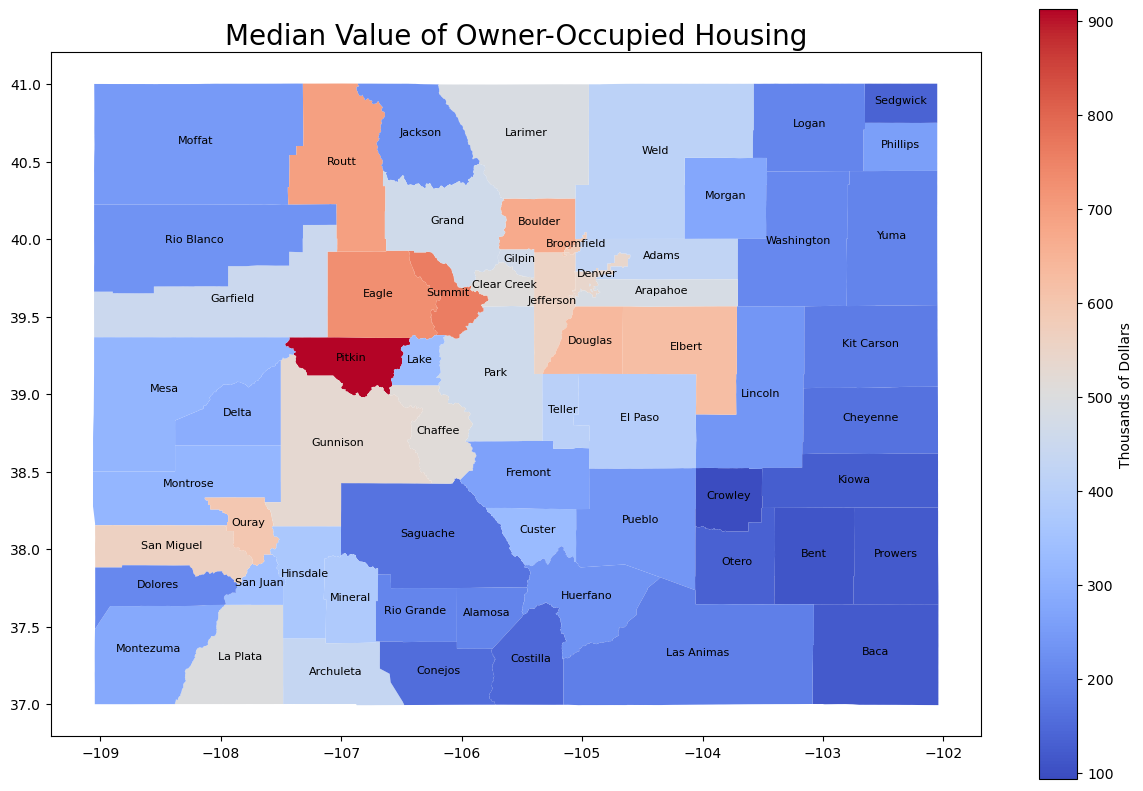

In [18]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (15, 10))

# Plot data
county_df.plot(column = "MEDIANVALUE",
                       ax = ax,
                       cmap = "coolwarm",
                       legend_kwds={"label": "Thousands of Dollars", "orientation": "vertical"},
                       legend = True)

# Add text annotations for each geometry
for idx, row in county_df.iterrows():
    ax.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), color='black', fontsize=8, ha='center')

# Stylize plots
plt.style.use('fast')

# Set title
ax.set_title('Median Value of Owner-Occupied Housing', fontdict = {'fontsize': '20', 'fontweight' : '3'})

# Save figure
plt.savefig('images/med_value_2022.png')

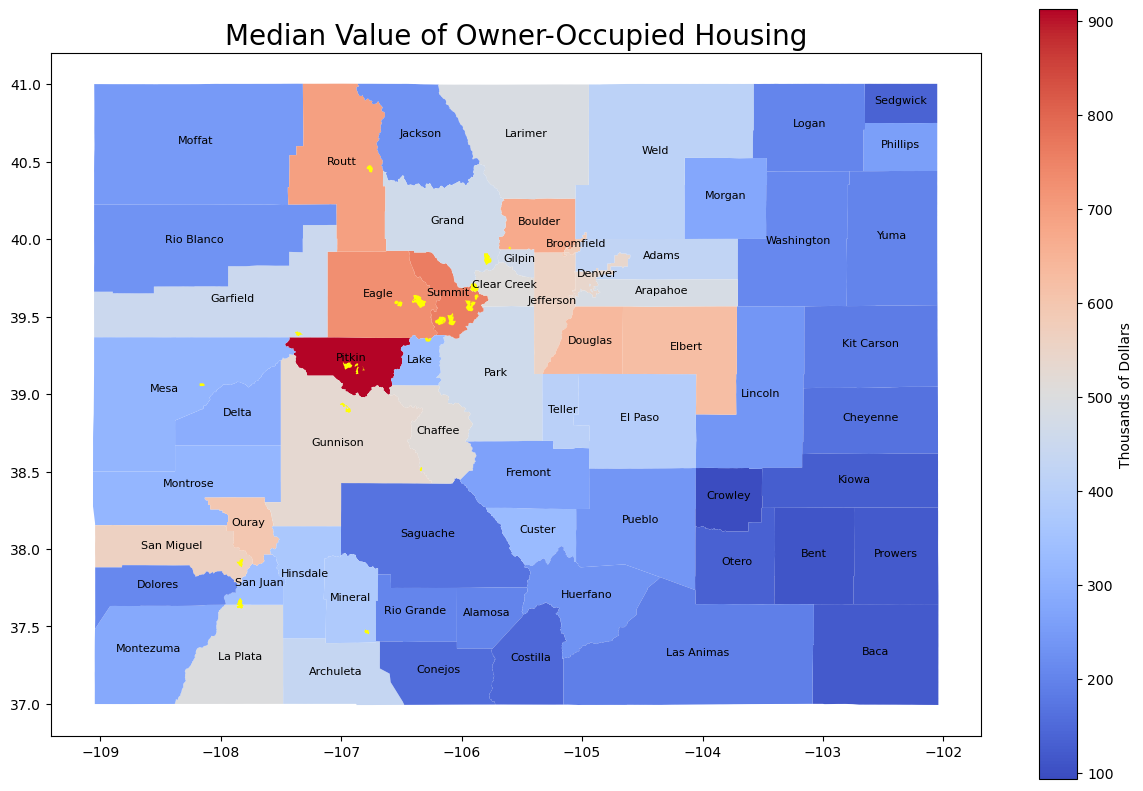

In [19]:
# Load in ski area boundaries
# Found at: https://www.fs.usda.gov/detail/roadless/coloradoroadlessrules/?cid=stelprdb5291441
ski_areas = gpd.read_file('data/stelprdb5145323/CO_ski_areas_13may2009.shp')
ski_areas = ski_areas.to_crs('EPSG:4326')

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (15, 10))

# Plot data
county_df.plot(column = "MEDIANVALUE",
                       ax = ax,
                       cmap = "coolwarm",
                       legend_kwds={"label": "Thousands of Dollars", "orientation": "vertical"},
                       legend = True)

# Add text annotations for each geometry
for idx, row in county_df.iterrows():
    ax.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), color='black', fontsize=8, ha='center')

# Stylize plots
plt.style.use('fast')

# Plot the polygons from the second GeoDataFrame on top
ski_areas.plot(ax=ax, color='yellow', alpha=1)

# Set title
ax.set_title('Median Value of Owner-Occupied Housing', fontdict = {'fontsize': '20', 'fontweight' : '3'})

# Save figure
plt.savefig('images/med_value_2022_w_resorts.png')